## This notebook compares and visualizes the results of 2 models.

In [2]:
# Import

In [1]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import time
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123
from sklearn.decomposition import PCA
import pandas as pd

from pandas.core import base
from utils import *  # bad practice, nvm

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from dataset import NumpyDataset, TransformerEnsembleDataset, TrainSamplerMultiClass, TrainSampler, TrainSamplerMultiClassUnit
from models import AggregateFeatEnsemble, DynamicWeightEnsemble, LogisticRegression, BertClassiferHyperparams, SimpleEnsemble, FixedWeightEnsemble
from tqdm import tqdm
import time
import torch.nn.functional as F
from contrastive_utils import compute_sim_matrix, compute_target_matrix, contrastive_loss

ckpt_dir = 'exp_data'

[nltk_data] Downloading package stopwords to /home/aibo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/aibo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# specify ids of the 2 models
model1 = "1b_s62B"
model2 = "1a_s62B"

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Load features of the 2 models

In [3]:
output_list_1 = torch.load("./exp_data/output_list_" + model1 + ".pt").cpu().numpy() 
feature_list_1 = torch.load("./exp_data/feature_list_" + model1 + ".pt").cpu().numpy()
label_list_1 = torch.load("./exp_data/label_list_" + model1 + ".pt")
output_list_2 = torch.load("./exp_data/output_list_" + model2 + ".pt").cpu().numpy()
feature_list_2 = torch.load("./exp_data/feature_list_" + model2 + ".pt").cpu().numpy()
label_list_2 = torch.load("./exp_data/label_list_" + model2 + ".pt")

truth_list_1 = []
truth_list_2 = []
for l1, l2 in zip(label_list_1, label_list_2):
    l1 = l1.cpu().numpy().astype(np.int32)
    l2 = l2.cpu().numpy().astype(np.int32)
    truth_list_1 = np.concatenate((truth_list_1, l1))
    truth_list_2 = np.concatenate((truth_list_2, l2))
truth_label_1 = truth_list_1.astype(np.int64)
truth_label_2 = truth_list_2.astype(np.int64)
pred_label_1 = np.argmax(output_list_1, axis=1)
pred_label_2 = np.argmax(output_list_2, axis=1)

In [4]:
print(len(truth_label_1))
print(len(truth_label_2))

2928
2928


### Class-Wise Accuracy

In [5]:
n_classes = 10
class_acc_dic = {} # for each class's samples, how many are correctly predicted and how many are falsely predicted
for c in range(n_classes):
    class_acc_dic[c] = {}
    class_acc_dic[c][model1] = {}
    class_acc_dic[c][model2] = {}
    class_acc_dic[c][model1]["T"] = 0
    class_acc_dic[c][model1]["F"] = 0
    class_acc_dic[c][model2]["T"] = 0
    class_acc_dic[c][model2]["F"] = 0
for (tl1, pl1, tl2, pl2) in zip(truth_label_1, pred_label_1, truth_label_2, pred_label_2):
    if tl1 == pl1:
        class_acc_dic[tl1][model1]["T"] += 1
    else:
        class_acc_dic[tl1][model1]["F"] += 1
    if tl2 == pl2:
        class_acc_dic[tl2][model2]["T"] += 1
    else:
        class_acc_dic[tl2][model2]["F"] += 1
acc_imp = {}
failed_class = []
X = []
acc1_list = []
acc2_list = []
size_list = []
total_size = 0
print("======================================")
for c in range(n_classes):
    acc1 = class_acc_dic[c][model1]["T"] / (class_acc_dic[c][model1]["T"] + class_acc_dic[c][model1]["F"])
    acc2 = class_acc_dic[c][model2]["T"] / (class_acc_dic[c][model2]["T"] + class_acc_dic[c][model2]["F"])
    size = class_acc_dic[c][model1]["T"] + class_acc_dic[c][model1]["F"]
    total_size += size
    print("class " + str(c) + " acc1: " + str(acc1) + " acc2: " + str(acc2) + " size: " + str(size)) 
    acc_imp[c] = acc1 - acc2
    # if acc1 - acc2 < -0.05:
    if True:
        failed_class.append((c, acc1 - acc2))
        X.append(str(c))
        acc1_list.append(acc1)
        acc2_list.append(acc2)
        size_list.append(size)
print("======================================")

print("Classes where model 1 (severely) fails to outperform model 2")
for f in failed_class:
    print(str(f[0]) + " : " + str(f[1]))
    
print("======================================")


    

class 0 acc1: 0.9053030303030303 acc2: 0.9242424242424242 size: 264
class 1 acc1: 0.9847328244274809 acc2: 0.9904580152671756 size: 524
class 2 acc1: 0.35789473684210527 acc2: 0.017543859649122806 size: 285
class 3 acc1: 0.0 acc2: 0.0034965034965034965 size: 286
class 4 acc1: 0.9453125 acc2: 0.97265625 size: 256
class 5 acc1: 0.9428571428571428 acc2: 0.10357142857142858 size: 280
class 6 acc1: 0.0035842293906810036 acc2: 0.07168458781362007 size: 279
class 7 acc1: 0.831275720164609 acc2: 0.8353909465020576 size: 243
class 8 acc1: 0.8739130434782608 acc2: 0.8956521739130435 size: 230
class 9 acc1: 0.03202846975088968 acc2: 0.010676156583629894 size: 281
Classes where model 1 (severely) fails to outperform model 2
0 : -0.018939393939393923
1 : -0.005725190839694694
2 : 0.34035087719298246
3 : -0.0034965034965034965
4 : -0.02734375
5 : 0.8392857142857143
6 : -0.06810035842293906
7 : -0.004115226337448541
8 : -0.021739130434782705
9 : 0.021352313167259787


In [8]:
decrease_sum = 0.0
for a1, a2, s in zip(acc1_list, acc2_list, size_list):
    decrease_sum += (a1 - a2) * s
print(decrease_sum / total_size)

0.1014344262295082


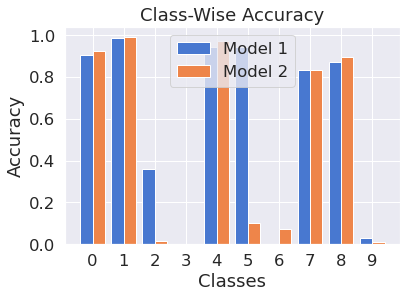

In [6]:
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, acc1_list, 0.4, label = 'Model 1')
plt.bar(X_axis + 0.2, acc2_list, 0.4, label = 'Model 2')
  
plt.xticks(X_axis, X)
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Class-Wise Accuracy")
plt.legend()
plt.show()

In [10]:
cm1 = confusion_matrix(truth_label_1, pred_label_1, normalize='all')
# f1 = sns.heatmap(cm1, annot=True)
cm2 = confusion_matrix(truth_label_2, pred_label_2, normalize='all')
# f2 = sns.heatmap(cm2, annot=True)

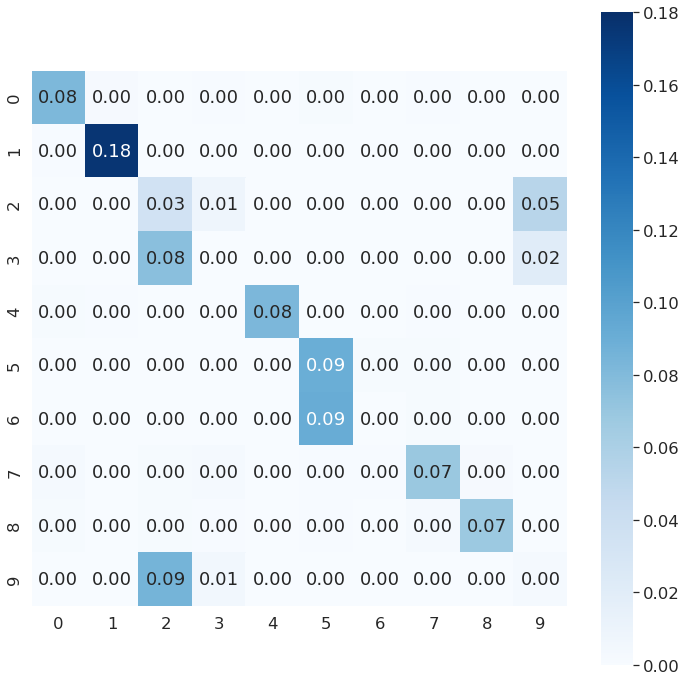

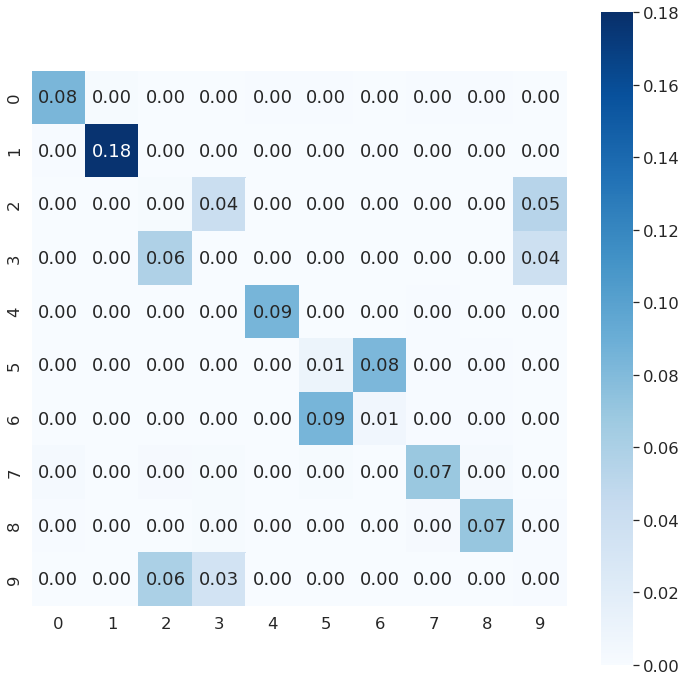

In [29]:
# with sns.axes_style("white"):
f1, ax1 = plt.subplots(figsize=(12, 12))
ax1 = sns.heatmap(cm1 ,vmax=0.18, square=True, cmap='Blues', annot=True, fmt='.2f')
f1.savefig('matrix_proposed.png', dpi=1080) 
f2, ax2 = plt.subplots(figsize=(12, 12))
ax2 = sns.heatmap(cm2 ,vmax=0.18, square=True, cmap='Blues', annot=True, fmt='.2f')
f2.savefig('matrix_baseline.png', dpi=1080) 

In [26]:
np.max(cm2)

0.17725409836065573

###  Visualization

In [7]:
def scatter(x, colors, image_name):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int64)])
    plt.xlim(-80, 80)
    plt.ylim(-80, 80)
    # ax.axis('on')
   #  ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    f.savefig(image_name, dpi=1080) 

    return f, ax, sc, txts

def pca_visualize(pool, colors, image_name):
    time_start = time.time()

    pca = PCA(n_components=4)
    pca_result = pca.fit_transform(pool)

    print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

    pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

    pca_df['pca1'] = pca_result[:,0]
    pca_df['pca2'] = pca_result[:,1]
    pca_df['pca3'] = pca_result[:,2]
    pca_df['pca4'] = pca_result[:,3]

    print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))

    top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
    
    scatter(top_two_comp.values,colors, image_name)
    
def tsne_visualize(pool, colors, image_name):
    RS = 123
    model_tsne = TSNE(random_state=RS).fit_transform(pool)
    # /np.max(model_tsne)
    scatter(model_tsne, colors, image_name)

In [8]:
viewed_samples = -1 # number of points to be seen
pool1 = feature_list_1[:viewed_samples]
print(pool1.shape)
colors1 = truth_label_1[:viewed_samples]
print(len(colors1))
pool2 = feature_list_2[:viewed_samples]
print(pool2.shape)
colors2 = truth_label_2[:viewed_samples]
print(len(colors2))

(2927, 100)
2927
(2927, 100)
2927


PCA done! Time elapsed: 0.08021306991577148 seconds
Variance explained per principal component: [0.4429224  0.36347315 0.07996611 0.07166769]
PCA done! Time elapsed: 0.0053157806396484375 seconds
Variance explained per principal component: [0.19146651 0.08283769 0.06831628 0.02842761]


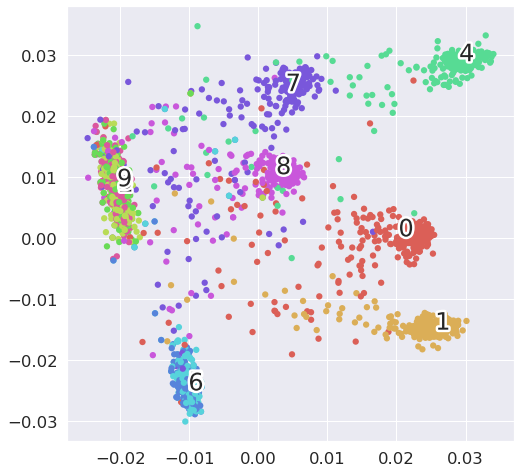

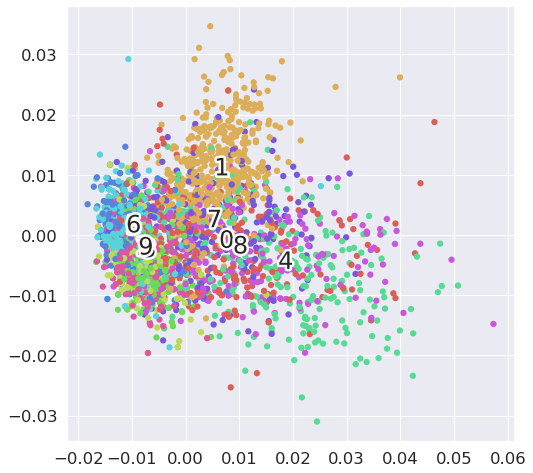

In [32]:
# sample run of pca
pca_visualize(pool1, colors1, "pca_proposed.png")
pca_visualize(pool2, colors2, "pca_baseline.png")

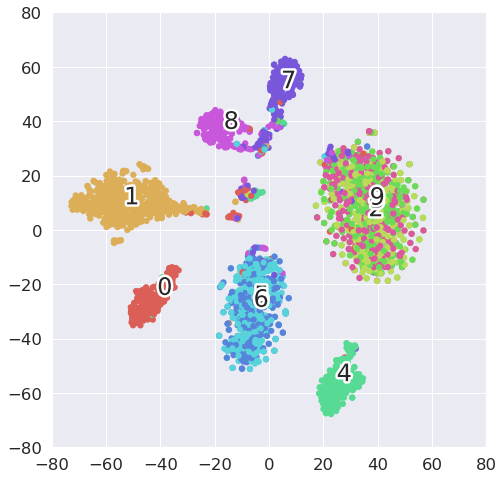

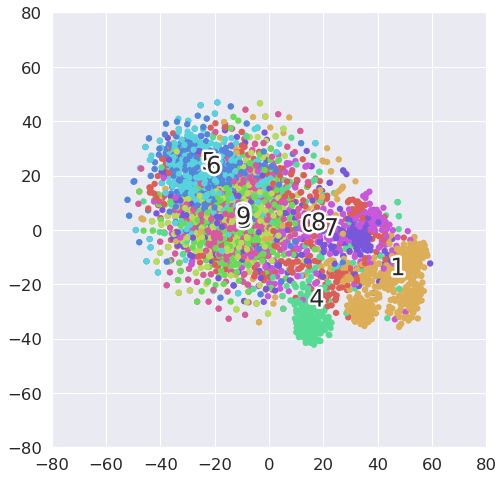

In [10]:
tsne_visualize(pool1, colors1, "tsne_proposed.png")
tsne_visualize(pool2, colors2, "tsne_baseline.png")